## Modules & Helpful Functions

In [1]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pandas as pd,pylab as pl
import h5py,tensorflow_hub as th
import tensorflow as tf
import skimage.transform as st
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Dropout
from keras.layers import Flatten,Input,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
fpath2='../input/classification-of-handwritten-letters/'
fw='weights.syn.hdf5'
def img_rotate(image,size):
        angle=np.random.randint(-15,15)
        img=st.rotate(image,angle,resize=True)
        img=st.resize(img,(size,size))
        return np.array(img*255,dtype=np.uint8)
def label5symbols(label,symbol):
    length=len(label)
    if length>=5:
        return label
    else:
        no_labels=np.full((5-length),symbol)
        res=np.concatenate((no_labels,label),axis=0)
        return np.array(res,dtype=np.uint8)
def concat5symbols(i,rx,y,size,symbol):
    k=np.random.randint(1,6)
    img=rx[i]; label=y[i]
    for j in range(1,k):
        img=np.concatenate((img,rx[i+j]),axis=1)
        label=np.concatenate((label,y[i+j]),axis=0)
    if k!=5:
        w1=np.random.randint(0,size*5-img.shape[1])
        w2=size*5-img.shape[1]-w1        
        img=np.concatenate((np.zeros((size,w1)),img,
                            np.zeros((size,w2))),axis=1)
    img=np.array(img,dtype=np.uint8)
    label=label5symbols(label,symbol)
    return [img,label,k]

## Synthetic Data #1

In [3]:
(x_train1,y_train1),(x_test1,y_test1)=\
tf.keras.datasets.mnist.load_data()
y_train1=y_train1.reshape(-1,1)
y_test1=y_test1.reshape(-1,1)
pd.DataFrame([[x_train1.shape,x_test1.shape,x_train1.dtype],
              [y_train1.shape,y_test1.shape,y_train1.dtype]],
             columns=['train','test','dtype'],
             index=['images','labels'])

11493376/11490434 [==============================] - 0s 0us/step


,train,test,dtype
images,"(60000, 28, 28)","(10000, 28, 28)",uint8
labels,"(60000, 1)","(10000, 1)",uint8


In [4]:
rx_train1=np.array([img_rotate(x_train1[i],28)
                    for i in range(x_train1.shape[0])])
rx_test1=np.array([img_rotate(x_test1[i],28)
                   for i in range(x_test1.shape[0])])

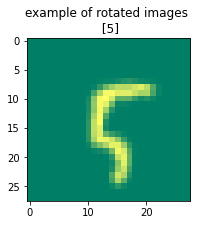

In [5]:
pl.figure(figsize=(3,3))
pl.imshow(rx_train1[100],cmap=pl.cm.summer)
pl.title('example of rotated images \n %s'%y_train1[100]);

In [6]:
sx_train1=np.empty([rx_train1.shape[0],28,140])
sy_train1=np.empty([y_train1.shape[0],5])
i=0; c=0
while i<rx_train1.shape[0]-5:
    [image,label,k]=\
    concat5symbols(i,rx_train1,y_train1,28,10)
    sx_train1[c]=image; sy_train1[c]=label
    c+=1; i+=k
sx_train1=np.array(sx_train1[:c],dtype=np.uint8)
sy_train1=np.array(sy_train1[:c],dtype=np.uint8)
[sx_train1.shape,sy_train1.shape]

[(19873, 28, 140), (19873, 5)]

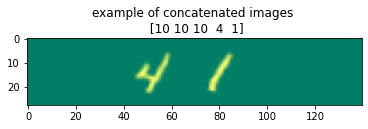

In [7]:
pl.imshow(sx_train1[100],cmap=pl.cm.summer);
pl.title('example of concatenated images \n %s'%\
         sy_train1[100]);

In [8]:
sx_test1=np.empty([rx_test1.shape[0],28,140])
sy_test1=np.empty([y_test1.shape[0],5])
i=0; c=0
while i<rx_test1.shape[0]-5:
    [image,label,k]=\
    concat5symbols(i,rx_test1,y_test1,28,10)
    sx_test1[c]=image; sy_test1[c]=label
    c+=1; i+=k
sx_test1=np.array(sx_test1[:c],dtype=np.uint8)
sy_test1=np.array(sy_test1[:c],dtype=np.uint8)
[sx_test1.shape,sy_test1.shape]

[(3377, 28, 140), (3377, 5)]

In [9]:
sx_train1=sx_train1.reshape(-1,28,28*5,1)
sx_test1=sx_test1.reshape(-1,28,28*5,1)
n=int(len(sx_test1)/2)
sx_valid1,sy_valid1=sx_test1[:n],sy_test1[:n]
sx_test1,sy_test1=sx_test1[n:],sy_test1[n:]
sy_train1_list=[sy_train1[:,i] for i in range(5)]
sy_valid1_list=[sy_valid1[:,i] for i in range(5)]
sy_test1_list=[sy_test1[:,i] for i in range(5)]
print('Reshape the train set for models')
print(sx_train1.shape,sy_train1_list[0].shape)

Reshape the train set for models
(19873, 28, 140, 1) (19873,)


## Synthetic Data #2

In [10]:
f=h5py.File(fpath2+'LetterColorImages_123.h5','r') 
keys=list(f.keys())
letters=u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
images=np.array(f[keys[1]])/255
images=.7-np.dot(images[...,:3],[.299,.587,.114])**2
images=np.array(images*255,dtype=np.uint8)
labels=np.array(f[keys[2]],dtype=np.uint8).reshape(-1,1)-1
x_train2,x_test2,y_train2,y_test2=\
train_test_split(images,labels,test_size=.2,random_state=1)
pd.DataFrame([[x_train2.shape,x_test2.shape,x_train2.dtype],
              [y_train2.shape,y_test2.shape,y_train2.dtype]],
             columns=['train','test','dtype'],
             index=['images','labels'])

,train,test,dtype
images,"(11352, 32, 32)","(2838, 32, 32)",uint8
labels,"(11352, 1)","(2838, 1)",uint8


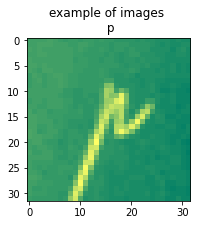

In [11]:
pl.figure(figsize=(3,3))
pl.imshow(x_train2[100],cmap=pl.cm.summer)
pl.title('example of images \n %s'%\
         letters[y_train2[100][0]]);

In [12]:
sx_train2=np.empty([x_train2.shape[0],32,160])
sy_train2=np.empty([y_train2.shape[0],5])
i=0; c=0
while i<x_train2.shape[0]-5:
    [image,label,k]=\
    concat5symbols(i,x_train2,y_train2,32,33)
    sx_train2[c]=image; sy_train2[c]=label
    c+=1; i+=k
sx_train2=np.array(sx_train2[:c],dtype=np.uint8)
sy_train2=np.array(sy_train2[:c],dtype=np.uint8)
[sx_train2.shape,sy_train2.shape]

[(3832, 32, 160), (3832, 5)]

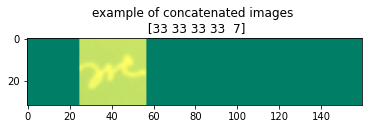

In [13]:
pl.imshow(sx_train2[100],cmap=pl.cm.summer);
pl.title('example of concatenated images \n %s'%\
         sy_train2[100]);

In [14]:
sx_test2=np.empty([x_test2.shape[0],32,160])
sy_test2=np.empty([y_test2.shape[0],5])
i=0; c=0
while i<x_test2.shape[0]-5:
    [image,label,k]=\
    concat5symbols(i,x_test2,y_test2,32,33)
    sx_test2[c]=image; sy_test2[c]=label
    c+=1; i+=k
sx_test2=np.array(sx_test2[:c],dtype=np.uint8)
sy_test2=np.array(sy_test2[:c],dtype=np.uint8)
[sx_test2.shape,sy_test2.shape]

[(938, 32, 160), (938, 5)]

In [15]:
sx_train2=sx_train2.reshape(-1,32,32*5,1)
sx_test2=sx_test2.reshape(-1,32,32*5,1)
n=int(len(sx_test2)/2)
sx_valid2,sy_valid2=sx_test2[:n],sy_test2[:n]
sx_test2,sy_test2=sx_test2[n:],sy_test2[n:]
sy_train2_list=[sy_train2[:,i] for i in range(5)]
sy_valid2_list=[sy_valid2[:,i] for i in range(5)]
sy_test2_list=[sy_test2[:,i] for i in range(5)]
print('Reshape the train set for models')
print(sx_train2.shape,sy_train2_list[0].shape)

Reshape the train set for models
(3832, 32, 160, 1) (3832,)


## CNN
### Synthetic Data #1

In [16]:
def syn_model1(size,n):    
    model_input=Input(shape=(size,size*5,1))
    x=BatchNormalization()(model_input)        
    x=Conv2D(32,(5,5),activation='relu',
             padding='same')(model_input)
    x=MaxPooling2D(pool_size=(2,2))(x)     
    x=Conv2D(32,(5,5),activation='relu',
             padding='same')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)    
    x=Dropout(.25)(x)
    x=BatchNormalization()(x)
    x=Conv2D(196,(5,5),activation='relu',
             padding='same')(x) 
    x=MaxPooling2D(pool_size=(2,2))(x) 
    x=Dropout(.25)(x)    
    x=Conv2D(196,(5,5),activation='relu',
             padding='same')(x)
    x=MaxPooling2D(pool_size=(2,2))(x) 
    x=Dropout(.25)(x)              
    x=Flatten()(x)    
    x=Dense(512,activation='relu')(x)    
    x=Dropout(.25)(x)    
    y=[Dense(n,activation='softmax')(x)
       for i in range(5)]
    model=Model(input=model_input,output=y)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model

In [17]:
syn_model1=syn_model1(28,11)
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,
                             save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.5)
syn_model1.fit(sx_train1,sy_train1_list, 
               validation_data=(sx_valid1,sy_valid1_list), 
               epochs=30,batch_size=128,verbose=2,
               callbacks=[checkpointer,lr_reduction])

Train on 19873 samples, validate on 1688 samples
Epoch 1/30
 - 10s - loss: 7.2379 - dense_2_loss: 0.5529 - dense_3_loss: 0.9960 - dense_4_loss: 1.4570 - dense_5_loss: 1.9214 - dense_6_loss: 2.3035 - dense_2_accuracy: 0.8190 - dense_3_accuracy: 0.6566 - dense_4_accuracy: 0.4881 - dense_5_accuracy: 0.3208 - dense_6_accuracy: 0.1622 - val_loss: 5.0729 - val_dense_2_loss: 0.3083 - val_dense_3_loss: 0.6404 - val_dense_4_loss: 1.0097 - val_dense_5_loss: 1.3484 - val_dense_6_loss: 1.7022 - val_dense_2_accuracy: 0.9046 - val_dense_3_accuracy: 0.7814 - val_dense_4_accuracy: 0.6540 - val_dense_5_accuracy: 0.5456 - val_dense_6_accuracy: 0.4455

Epoch 00001: val_loss improved from inf to 5.07290, saving model to weights.syn.hdf5
Epoch 2/30
 - 5s - loss: 3.7183 - dense_2_loss: 0.2458 - dense_3_loss: 0.5191 - dense_4_loss: 0.7932 - dense_5_loss: 1.0447 - dense_6_loss: 1.1113 - dense_2_accuracy: 0.9174 - dense_3_accuracy: 0.8204 - dense_4_accuracy: 0.7264 - dense_5_accuracy: 0.6311 - dense_6_accuracy

In [18]:
syn_model1.load_weights(fw)
syn_scores1=syn_model1.evaluate(sx_test1,sy_test1_list,verbose=0)
print("Scores: \n" ,(syn_scores1))
print("First digit. Accuracy: %.2f%%"%(syn_scores1[6]*100))
print("Second digit. Accuracy: %.2f%%"%(syn_scores1[7]*100))
print("Third digit. Accuracy: %.2f%%"%(syn_scores1[8]*100))
print("Fourth digit. Accuracy: %.2f%%"%(syn_scores1[9]*100))
print("Fifth digit. Accuracy: %.2f%%"%(syn_scores1[10]*100))
avg_accuracy1=sum([syn_scores1[i] for i in range(6,11)])/5
print("Synthetic MNIST. Average Accuracy: %.2f%%"%(avg_accuracy1*100))

Scores: 
 [0.0702281215513768, 0.002865367103368044, 0.013230834156274796, 0.015640733763575554, 0.019214456900954247, 0.018993744626641273, 0.999407947063446, 0.9976317286491394, 0.9970396757125854, 0.9946714043617249, 0.9934872984886169]
First digit. Accuracy: 99.94%
Second digit. Accuracy: 99.76%
Third digit. Accuracy: 99.70%
Fourth digit. Accuracy: 99.47%
Fifth digit. Accuracy: 99.35%
Synthetic MNIST. Average Accuracy: 99.64%


### Synthetic Data #2

In [19]:
def syn_model2(size,n):    
    model_input=Input(shape=(size,size*5,1))
    x=BatchNormalization()(model_input)        
    x=Conv2D(32,(5,5),activation='relu',
             padding='same')(model_input)
    x=MaxPooling2D(pool_size=(2,2))(x)     
    x=Conv2D(32,(5,5),activation='relu',
             padding='same')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)    
    x=Dropout(.25)(x)
    x=BatchNormalization()(x)
    x=Conv2D(256,(5,5),activation='relu',
             padding='same')(x) 
    x=MaxPooling2D(pool_size=(2,2))(x) 
    x=Dropout(.25)(x)    
    x=Conv2D(256,(5,5),activation='relu',
             padding='same')(x)
    x=MaxPooling2D(pool_size=(2,2))(x) 
    x=Dropout(.25)(x)              
    x=Flatten()(x)    
    x=Dense(1024,activation='relu')(x)    
    x=Dropout(.25)(x)    
    y=[Dense(n,activation='softmax')(x)
       for i in range(5)]
    model=Model(input=model_input,output=y)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model

In [20]:
syn_model2=syn_model2(32,34)
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,
                             save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.5)
estopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
syn_model2.fit(sx_train2,sy_train2_list, 
               validation_data=(sx_valid2,sy_valid2_list), 
               epochs=100,batch_size=64,verbose=2,
               callbacks=[checkpointer,lr_reduction,estopping])

Train on 3832 samples, validate on 469 samples
Epoch 1/100
 - 3s - loss: 11.6879 - dense_8_loss: 0.8303 - dense_9_loss: 1.6115 - dense_10_loss: 2.4070 - dense_11_loss: 3.1525 - dense_12_loss: 3.6834 - dense_8_accuracy: 0.8040 - dense_9_accuracy: 0.6046 - dense_10_accuracy: 0.3938 - dense_11_accuracy: 0.1999 - dense_12_accuracy: 0.0305 - val_loss: 11.1283 - val_dense_8_loss: 0.7270 - val_dense_9_loss: 1.6610 - val_dense_10_loss: 2.3247 - val_dense_11_loss: 2.9668 - val_dense_12_loss: 3.5422 - val_dense_8_accuracy: 0.8209 - val_dense_9_accuracy: 0.5885 - val_dense_10_accuracy: 0.4094 - val_dense_11_accuracy: 0.2367 - val_dense_12_accuracy: 0.0299

Epoch 00001: val_loss improved from inf to 11.12825, saving model to weights.syn.hdf5
Epoch 2/100
 - 2s - loss: 10.7096 - dense_8_loss: 0.6701 - dense_9_loss: 1.3944 - dense_10_loss: 2.1569 - dense_11_loss: 2.9270 - dense_12_loss: 3.5620 - dense_8_accuracy: 0.8171 - dense_9_accuracy: 0.6279 - dense_10_accuracy: 0.4248 - dense_11_accuracy: 0.221

In [21]:
syn_model2.load_weights(fw)
syn_scores2=syn_model2.evaluate(sx_test2,sy_test2_list,verbose=0)
print("Scores: \n" ,(syn_scores2))
print("First letter. Accuracy: %.2f%%"%(syn_scores2[6]*100))
print("Second letter. Accuracy: %.2f%%"%(syn_scores2[7]*100))
print("Third letter. Accuracy: %.2f%%"%(syn_scores2[8]*100))
print("Fourth letter. Accuracy: %.2f%%"%(syn_scores2[9]*100))
print("Fifth letter. Accuracy: %.2f%%"%(syn_scores2[10]*100))
avg_accuracy2=sum([syn_scores2[i] for i in range(6,11)])/5
print("Synthetic Letters. Average Accuracy: %.2f%%"%(avg_accuracy2*100))

Scores: 
 [10.682964894308972, 0.7363604307174683, 1.423814058303833, 2.1935105323791504, 2.861429452896118, 3.474646806716919, 0.7953091859817505, 0.6055437326431274, 0.3987206816673279, 0.21961620450019836, 0.057569295167922974]
First letter. Accuracy: 79.53%
Second letter. Accuracy: 60.55%
Third letter. Accuracy: 39.87%
Fourth letter. Accuracy: 21.96%
Fifth letter. Accuracy: 5.76%
Synthetic Letters. Average Accuracy: 41.54%
